In [1]:
# Load sentence retrieval result
import json 
with open("/gallery_louvre/dayoon.ko/research/sds/retrieval/results/multilingual-e5-large/trec-covid-gpt-queries-retrieval.jsonl") as f:
    result = [json.loads(i) for i in f.readlines()]

In [2]:
# Load csv file for recall, precision, and f1
import pandas as pd
path = "/gallery_louvre/dayoon.ko/research/sds/retrieval/results/multilingual-e5-large/trec-covid-n-query-mt-2.csv"
df = pd.read_csv(path)
df = df.drop('Unnamed: 0', axis=1)
df = df.set_index("corpus-id")

In [3]:
# Get grad norm dict

pth = "/gallery_louvre/dayoon.ko/research/sds/eval_retrieval/BGE_M3/"

def load_file(pth):
    with open(pth) as f:
        lines = f.readlines() 
    return lines 
    
def get_gradnorms(pth):
    lines = load_file(pth)
    gradnorms = []
    for l in lines:
        try: 
            l = l.replace('\'', '"')
            item = json.loads(l)
            gradnorms.append(float(item["grad_norm"]))
            '''
            sid = l.index("tensor(") + len("tensor(") 
            eid = sid + 5
            gradnorms.append(float(l[sid:eid]))
            '''
        except:
            continue
    ids = []
    for l in lines:
        try:
            sid = l.index("doc_id: ") + len("doc_id: ") 
            eid = sid
            ids.append(l[sid:].strip())
        except:
            continue

    gradnorms_selected = []
    ids_selected = []
    func = lambda x: sum(x) / len(x)
    for i in range(0, len(ids), 8):
        gradnorms_selected.append(func(gradnorms[i:i+8]))
        ids_selected.append(ids[i])
    gradnorm_dict = {cid: gradnorm for cid, gradnorm in zip(ids_selected, gradnorms_selected)}
            
    return gradnorm_dict

gradnorm_dict = get_gradnorms(pth + "ood_all_update")

In [8]:
# Load result
scores = []
recalls = []
precisions = []
gradnorms = []
f1s = []
for i in result:
    cid = i["_id"]
    succ = sum(map(lambda x: cid in x, i["retrieval"][:100]))
    count = len(i["retrieval"])
    if count < 3:
        continue
    score = round(succ / count * 100, 2)
    scores.append(score)
    recalls.append(df.loc[cid]["recall"])
    precisions.append(df.loc[cid]["precision"])
    f1s.append(df.loc[cid]["f1"])
    gradnorms.append(gradnorm_dict[cid])
    

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(1069, 1069)

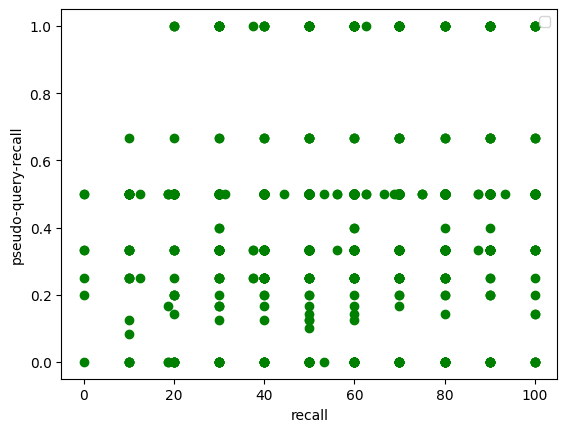

In [15]:
import matplotlib.pyplot as plt 
plt.figure()
plt.xlabel("recall")
plt.ylabel("pseudo-query-recall")
#plt.plot(ood_well_o, len(ood_well_o) * [0], "o" , label = "ood-well(tp_over_t>0.4)", color="blue")
#plt.plot(ood_poor, len(ood_poor) * [1], "x" , label = "ood-poor", color="red")

plt.scatter(scores, recalls, marker="o", color="green")
plt.legend()

len(scores), len(recalls)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(1069, 1069)

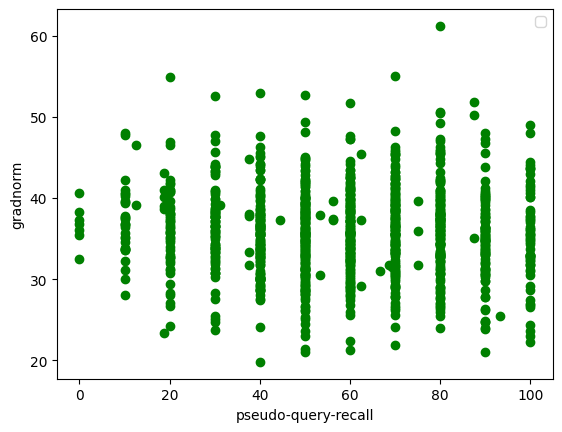

In [16]:
# Compare sentence recall to gradnorm

import matplotlib.pyplot as plt 
plt.figure()
plt.xlabel("pseudo-query-recall")
plt.ylabel("gradnorm")

plt.scatter(scores, gradnorms, marker="o", color="green")
plt.legend()

len(scores), len(gradnorms)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


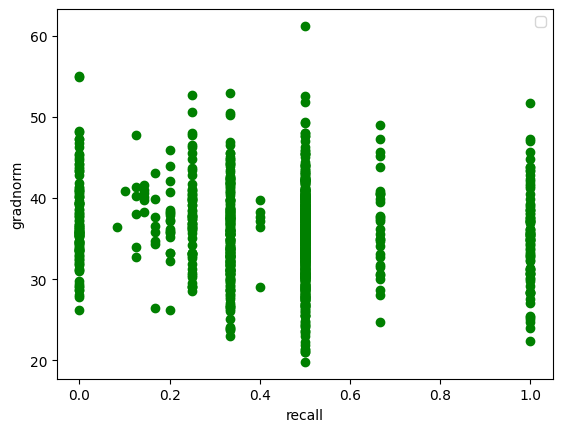

In [13]:
# Compare recall to gradnorm

import matplotlib.pyplot as plt 
plt.figure()
plt.xlabel("recall")
plt.ylabel("gradnorm")

plt.scatter(recalls, gradnorms, marker="o", color="green")
plt.legend()
 

### Load grad norm and plot mean 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


2500 2500 2500


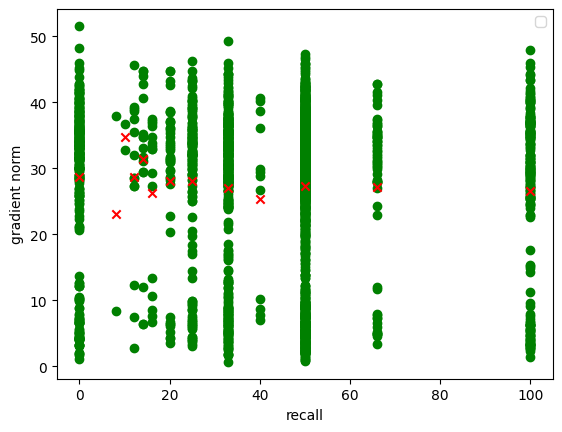

In [16]:
pth = "/gallery_louvre/dayoon.ko/research/sds/eval_retrieval/BGE_M3/"

def load_file(pth):
    with open(pth) as f:
        lines = f.readlines() 
    return lines 
    
def get_recall_and_score_list(pth):
    lines = load_file(pth)
    gradnorms = []
    for l in lines:
        try: 
            sid = l.index("tensor(") + len("tensor(") 
            eid = sid + 5
            gradnorms.append(float(l[sid:eid]))
        except:
            continue
    recalls = []
    for l in lines:
        try: 
            sid = l.index("recall: ") + len("recall: ") 
            eid = sid + 5
            recalls.append(int(float(l[sid:eid].strip()) * 100))
        except:
            continue
    ids = []
    for l in lines:
        try:
            sid = l.index("doc_id: ") + len("doc_id: ") 
            eid = sid
            ids.append(l[sid:].strip())
        except:
            continue

    gradnorms_selected = []
    recalls_selected = []
    ids_selected = []
    func = min #lambda x: sum(x) / len(x)
    for i in range(0, len(ids), 4):
        gradnorms_selected.append(func(gradnorms[i:i+4]))
        recalls_selected.append(func(recalls[i:i+4]))
        ids_selected.append(ids[i])
            
    return recalls_selected, gradnorms_selected, ids_selected



ood_all = pth + "ood_all_update"
recalls, gradnorms, ids = get_recall_and_score_list(ood_all)
print(len(recalls), len(gradnorms), len(ids))

import matplotlib.pyplot as plt 
plt.figure()
plt.scatter(recalls, gradnorms, color="green")
plt.xlabel("recall")
plt.ylabel("gradient norm")
#plt.plot(ood_well_o, len(ood_well_o) * [0], "o" , label = "ood-well(tp_over_t>0.4)", color="blue")
#plt.plot(ood_poor, len(ood_poor) * [1], "x" , label = "ood-poor", color="red")

means = {k: [] for k in set(recalls)}
for r, g in zip(recalls, gradnorms):
    means[r].append(g)
means = {k: sum(v) / len(v) for k, v in means.items()}
means = sorted(list(means.items()), key= lambda x: int(x[0]))
xs = [i[0] for i in means]
ys = [i[1] for i in means]
plt.scatter(xs, ys, marker="x", color="red")
plt.legend()
 